<a href="https://colab.research.google.com/github/fovi-com/MLTradingBot/blob/main/StockPricePredictionUsingTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The source of this notebook is (https://colab.research.google.com/drive/1j3AYSIxhiNJSCP692pKPbLk4_-kG4Pmh?usp=sharing) which accompanies this Medium article:  **Stock Price Prediction Using Transformers
Introduction: Evolving Landscape of Stock Price Prediction** (https://medium.com/@Matthew_Frank/stock-price-prediction-using-transformers-2d84341ff213).

Modifications by Jim White (https://www.linkedin.com/in/jamespaulwhite/).

In [1]:
%pip install python-dotenv

In [7]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [3]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D


In [4]:
tickers = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']

In [5]:
%load_ext dotenv

import os

if not os.environ.get('POLYGON_API_KEY'):
    try:
        from google.colab import userdata
        try:
            from google.colab import errors
            os.environ['POLYGON_API_KEY'] = userdata.get('POLYGON_API_KEY').strip()
        except Exception as ex:
            print(ex)
            pass
        except errors.Error as err:
            print(err)
            pass
    except ModuleNotFoundError:
        pass

    if not os.environ.get('POLYGON_API_KEY'):
        import getpass
        os.environ['POLYGON_API_KEY'] = getpass.getpass('Enter your Polygon API key: ').strip()

    if not os.environ.get('POLYGON_API_KEY'):
        raise ValueError('No Polygon API key provided')


API_KEY = os.getenv('POLYGON_API_KEY')

In [27]:
import requests
import pandas as pd
import os

# Function to get data from Polygon.io
def get_polygon_data(ticker, api_key, multiplier='1', timespan='minute', from_date='2022-01-01', to_date='2022-12-31'):
    url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{from_date}/{to_date}'
    params = {
        'adjusted': 'true',
        'sort': 'asc',
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data['results'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df


ticker_data_frames = []
stats = {}


from_date="2023-03-01"
to_date="2023-05-01"
data_folder = "data"

for ticker in tickers:
    saved_file_name = f'./{ticker}_{from_date}_{to_date}.csv'
    saved_file_path = os.path.join(data_folder, saved_file_name)
    # Download historical data for the ticker
    if os.path.exists(saved_file_path):
        data = pd.read_csv(saved_file_path)
    else:
        data = get_polygon_data(ticker, API_KEY, from_date=from_date, to_date=to_date)
        #create a folder if it does not exist
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        data.to_csv(saved_file_path)


    # Calculate the daily percentage change
    close = data['c']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['v']
    diff = close.diff(1)
    percent_change_close = close.pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close,
        ticker+'_width': width,
        ticker+'_rsi': rsi,
        ticker+'_roc': roc,
        ticker+'_volume': volume,
        ticker+'_diff': diff,
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
        stats[f"{column}_mean"] = MEAN[column]
        stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames.append(ticker_df)


In [ ]:
f"{len(ticker_data_frames)=}"

In [34]:
ticker_data_frames[3]

,AMZN_close,AMZN_width,AMZN_rsi,AMZN_roc,AMZN_volume,AMZN_diff,AMZN_percent_change_close
timestamp,,,,,,,
2023-03-01 09:00:00,0.889262,NaN,NaN,NaN,-0.653276,NaN,NaN
2023-03-01 09:01:00,1.049595,NaN,3.160380,NaN,-0.664037,2.972117,2.937619
2023-03-01 09:02:00,0.965611,NaN,1.008604,NaN,-0.673217,-1.557643,-1.536730
2023-03-01 09:03:00,0.950341,NaN,0.766961,NaN,-0.671779,-0.283648,-0.280473
2023-03-01 09:04:00,1.080135,NaN,1.564767,NaN,-0.658064,2.405897,2.375890
...,...,...,...,...,...,...,...
2023-03-09 17:54:00,0.977063,0.830705,-1.038007,-1.119351,0.668118,-0.779091,-0.769143
2023-03-09 17:55:00,0.946524,0.553118,-1.749664,-1.706029,0.123838,-0.566758,-0.559949
2023-03-09 17:56:00,1.003786,0.214091,-1.173823,-1.177988,0.231965,1.061125,1.047735


In [29]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,META_close_mean,META_close_std,META_width_mean,META_width_std,META_rsi_mean,META_rsi_std,META_roc_mean,META_roc_std,META_volume_mean,META_volume_std,...,GOOG_rsi_mean,GOOG_rsi_std,GOOG_roc_mean,GOOG_roc_std,GOOG_volume_mean,GOOG_volume_std,GOOG_diff_mean,GOOG_diff_std,GOOG_percent_change_close_mean,GOOG_percent_change_close_std
0,181.888926,5.064389,0.884587,0.62428,50.364641,17.046862,0.010671,0.353776,40953.215,58312.124902,...,49.670408,16.118251,0.002755,0.277204,38381.1966,51424.301577,0.000192,0.076649,0.000245,0.082652


In [35]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,META_close,META_width,META_rsi,META_roc,META_volume,META_diff,META_percent_change_close,AAPL_close,AAPL_width,AAPL_rsi,...,AMZN_volume,AMZN_diff,AMZN_percent_change_close,GOOG_close,GOOG_width,GOOG_rsi,GOOG_roc,GOOG_volume,GOOG_diff,GOOG_percent_change_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 10:55:00,-1.190455,-0.478390,-0.092067,-0.094443,-0.682452,0.873902,0.903757,-0.539978,-0.798726,1.183924,...,-0.674820,0.282572,0.278420,-1.211776,-0.548373,0.703956,0.506604,-0.740160,0.780287,0.795998
2023-03-01 12:00:00,-1.261539,-0.657236,-0.830519,-0.801155,-0.609431,-0.612235,-0.634117,-0.579376,-0.340900,-1.306480,...,-0.619763,-1.840753,-1.816162,-1.211776,-0.498211,-0.065720,-0.089276,-0.609579,-1.046229,-1.066610
2023-03-01 12:01:00,-1.281285,-0.663242,-0.600536,-0.528861,-0.675918,-0.557193,-0.577498,-0.576562,-0.351032,-1.212886,...,-0.637717,-0.566758,-0.560215,-1.243933,-0.498211,0.020448,-0.009939,-0.725731,-0.785298,-0.801400
2023-03-01 12:09:00,-1.285234,-0.438536,-0.233421,-0.223439,-0.674958,0.158355,0.163795,-0.573748,-0.943849,-0.826813,...,-0.656439,-0.708313,-0.700189,-1.227854,-0.386283,-0.379819,-0.327183,-0.726256,0.127960,0.130166
2023-03-01 13:00:00,-1.330649,-1.042758,-0.836138,-0.352565,-0.110838,-0.832403,-0.863530,-0.607518,-0.953176,-0.367317,...,-0.263616,-0.991423,-0.981247,-1.302887,-0.299948,-1.819765,-1.395900,-0.301729,-0.263436,-0.269550


In [36]:
# Shift the df data to create labels
labels = df.shift(-1)
# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]


In [37]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker
def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # + 12 because we want to predict the next hour
    for i in range(data_size - (sequence_length + 13)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i], labels[i + 11], mean[0], std[0]])

    return np.array(sequences), np.array(lab)

In [38]:
sequences_dict = {}
sequence_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequence_labels[ticker] = lab

In [39]:
sequences_dict['META'].shape

(3007, 24, 7)

In [40]:
sequences_dict['META'][2][-1]

array([-1.4491237 , -0.7667115 ,  0.46745801,  0.29408539, -0.68041106,
        0.26843901,  0.27930452])

In [41]:
sequence_labels['META'].shape

(3007, 4)

In [42]:
sequence_labels['META'][2]

array([ -1.43925084,  -1.53008114, 181.8889262 ,   5.06438907])

In [69]:
# Combine data and labels from all tickers

TRAIN_FRACTION = 0.8

train_sequences = []
train_labels = []
other_sequences = []
other_labels = []

def extend_sequences(ticker):
  ticker_sequence = sequences_dict[ticker]
  ticker_labels = sequence_labels[ticker]
  seq_len = len(ticker_sequence)
  assert seq_len == len(ticker_labels)
  train_len = int(seq_len * TRAIN_FRACTION)
  train_sequences.extend(ticker_sequence[:train_len])
  train_labels.extend(ticker_labels[:train_len])
  other_sequences.extend(ticker_sequence[train_len + SEQUENCE_LEN:])
  other_labels.extend(ticker_labels[train_len + SEQUENCE_LEN:])


for ticker in tickers:
    extend_sequences(ticker)

# Convert to numpy arrays
train_sequences = np.array(train_sequences)
train_labels = np.array(train_labels)
other_sequences = np.array(other_sequences)
other_labels = np.array(other_labels)

print(f"{train_sequences.shape=}")
print(f"{train_labels.shape=}")
print(f"{other_sequences.shape=}")
print(f"{other_labels.shape=}")

train_sequences.shape=(12025, 24, 7)
train_labels.shape=(12025, 4)
other_sequences.shape=(2890, 24, 7)
other_labels.shape=(2890, 4)


In [73]:
np.random.seed(42)

# Randomize the order of the training data
shuffled_indices = np.random.permutation(len(train_sequences))
train_sequences = train_sequences[shuffled_indices]
train_labels = train_labels[shuffled_indices]

# Validation/Test split is 50/50
# Need to leave gaps between the train, val, and test samples so they don't overlap in time.
val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[SEQUENCE_LEN:val_size]
validation_labels = other_labels[SEQUENCE_LEN:val_size]

test_sequences = other_sequences[val_size + SEQUENCE_LEN:]
test_labels = other_labels[val_size + SEQUENCE_LEN:]

print(f"{validation_sequences.shape=}")
print(f"{validation_labels.shape=}")
print(f"{test_sequences.shape=}")
print(f"{test_labels.shape=}")

validation_sequences.shape=(1421, 24, 7)
validation_labels.shape=(1421, 4)
test_sequences.shape=(1421, 24, 7)
test_labels.shape=(1421, 4)


In [74]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 24, 7)]              0         []                            
                                                                                                  
 layer_normalization_100 (L  (None, 24, 7)                14        ['input_5[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_48 (M  (None, 24, 7)                126983    ['layer_normalization_100[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_10

In [75]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [76]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

In [77]:
import matplotlib.pyplot as plt
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=False):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [78]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.2304 - dir_acc: 0.5264
Epoch 1: dir_acc improved from -inf to 0.52636, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.58628, saving model to transformer_val_model.keras
188/188 [==============================] - 54s 110ms/step - loss: 0.2304 - dir_acc: 0.5264 - val_loss: 0.1908 - val_dir_acc: 0.5863 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 0.1990 - dir_acc: 0.5349
Epoch 2: dir_acc improved from 0.52636 to 0.53492, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc did not improve from 0.58628
188/188 [==============================] - 18s 95ms/step - loss: 0.1990 - dir_acc: 0.5349 - val_loss: 0.1582 - val_dir_acc: 0.5554 - lr: 2.6333e-04

Epoch 3: LearningRateSche

In [105]:
# Load Weights
model.load_weights("transformer_val_model.keras")

# Make predictions
evaluation = model.evaluate(test_sequences, test_labels)
print(f"directional accuracy={evaluation[1]}")
print(model.metrics_names)
print(evaluation)

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

45/45 [==============================] - 1s 23ms/step - loss: 0.2595 - dir_acc: 0.5299
directional accuracy=0.5299144983291626
['loss', 'dir_acc']
[0.2594867944717407, 0.5299144983291626]
45/45 [==============================] - 1s 22ms/step
R-squared: 0.7390832367578763


In [97]:
results = pd.DataFrame({'actual':test_labels[:, 1], 'predicted':predictions[:, 0], 'error_ratio':(predictions[:, 0] - test_labels[:, 1])/test_labels[:, 1]})
results

,actual,predicted,error_ratio
0,-0.050764,0.093572,-2.843285
1,-0.089249,0.081537,-1.913594
2,-0.078058,0.072196,-1.924895
3,-0.113541,0.074804,-1.658833
4,-0.099894,0.058235,-1.582968
...,...,...,...
1416,1.116921,1.083238,-0.030156
1417,1.124960,1.135816,0.009651
1418,1.107381,1.102226,-0.004655
1419,1.098162,1.102886,0.004301


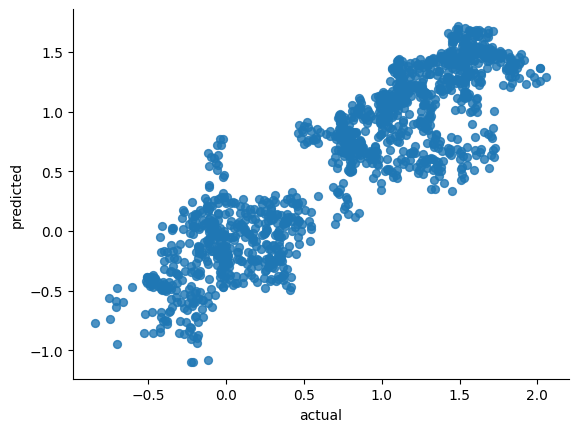

In [102]:
# @title actual vs predicted

from matplotlib import pyplot as plt
results.plot(kind='scatter', x='actual', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [101]:
results['error_ratio'].mean()

1.0346508603648905